In [1]:
from skimage import io
from matplotlib import pyplot as plt
from glob import glob
import numpy as np
from skimage.color import (separate_stains, combine_stains,
                            hdx_from_rgb, rgb_from_hdx,rgb2hed, hed2rgb) 

from skimage import img_as_ubyte
from skimage.exposure import rescale_intensity
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import precision_score,recall_score,accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

# Funciones


In [1]:
#Leer el conjunto de imagenes
def LeerImagenes(imagenes):
    imgs=[]
    for x in range(0,len(imagenes)):
        imgs.append(io.imread(imagenes[x]))
    MImagenes=np.array(imgs)
    
    return MImagenes

In [2]:
#Crea matriz con las etiquetas de las imagenes
def CalculoEtiquetas(imagenes):
    Etiquetas=[]
    for x in range(0,len(imagenes)):
        Clasificacion =imagenes[x].split('-') 
        for i in range(0,len(Clasificacion)) :
            Valores=(Clasificacion[2])
            Numero=Valores.split('_')
        Etiquetas.append(int(Numero[1]))
        #Etiquetas=np.array(etiquetas)
    return Etiquetas

In [3]:
#Aplico filtro al conjunto de imagenes ingresados cono paramentro
def AplicarFiltro(MImagenes):
    imgs_con_filtro=[]
    for x in range(0,len(MImagenes)):
        ihc_hdx = rgb2hed(MImagenes[x])
        null = np.zeros_like(ihc_hdx[:, :, 0])
        ihc_h = hed2rgb(np.stack((ihc_hdx[:, :, 0], null, null), axis=-1))
        ihc_d = hed2rgb(np.stack((null, ihc_hdx[:, :, 1], null), axis=-1))
        ihc_x = hed2rgb(np.stack((null, null, ihc_hdx[:, :, 2]), axis=-1))

        h = rescale_intensity(ihc_hdx[:, :, 0], out_range=(0, 1),
                      in_range=(0, np.percentile(ihc_hdx[:, :, 0], 99)))
        d = rescale_intensity(ihc_hdx[:, :, 2], out_range=(0, 1),
                      in_range=(0, np.percentile(ihc_hdx[:, :, 2], 99)))
    
        zdh = np.dstack((null, d, h))
        imgs_con_filtro.append(zdh)
    Imagenes_con_fitro=np.array(imgs_con_filtro)
    return Imagenes_con_fitro

In [4]:
#Obtiene el canal DAB de las imagenes representativas ingresadas
def ImagenDAB(MImagenes):
    imgs_DAB=[]
    for x in range(0,len(MImagenes)):
        ihc_hdx = rgb2hed(MImagenes[x])
        null = np.zeros_like(ihc_hdx[:, :, 0])
        #Seleccionó solo el canal DAB
        ihc_x = hed2rgb(np.stack((null, null, ihc_hdx[:, :, 2]), axis=-1)) 
        #Guardo solo el canal DAB 
        imgs_DAB.append(ihc_x)
    Imagenes_DAB=np.array(imgs_DAB)
    return Imagenes_DAB

In [5]:
#Obtiene los valores promedios de cada clase y los valores min y max de estos, segun las imagenes representativas ingresadas

def CalculoPromedios(Imagenes_DAB,Etiquetas):
    Prom0=[]
    Prom1=[]
    Prom2=[]
    Prom3=[]
    Prom_imgs=[]
    for x in range(0,len(Imagenes_DAB)):
        Promedio=np.mean(Imagenes_DAB[x])
        Prom_imgs.append(Promedio)
    for x in range(0,len(Etiquetas)):
        if Etiquetas[x]==0:
            Prom0.append(Prom_imgs[x])
        elif Etiquetas[x]==1:
            Prom1.append(Prom_imgs[x])
        elif Etiquetas[x]==2:
            Prom2.append(Prom_imgs[x])
        elif Etiquetas[x]==3:   
            Prom3.append(Prom_imgs[x])
        else:
            print("Error en la etiqueta") 
    Min0=min(Prom0)        
    Max0=max(Prom0)
    Min1=min(Prom1)
    Max1=max(Prom1)
    Min2=min(Prom2)
    Max2=max(Prom2)
    Min3=min(Prom3)
    Max3=max(Prom3)
    return Min0,Max0,Min1,Max1,Min2,Max2,Min3,Max3

In [6]:
#Filtra, quitando las imagenes que no cumplan con los valores asignados para su clase, retornando el conjunto de imagenes que 
#cumplen con los requisitos

def SemiFiltro(Imagenes,Etiquetas,Min0,Max0,Min1,Max1,Min2,Max2,Min3,Max3):
    Imgs=[]
    etqs=[]
    Imgs_DAB=ImagenDAB(Imagenes)
            
    for x in range(0,len(Imagenes)):
        Promedio=np.mean(Imgs_DAB[x])
        if Etiquetas[x]==0:
            if Promedio>=Min0 and Promedio<=Max0:
                Imgs.append(Imagenes[x])
                etqs.append(Etiquetas[x])
        elif Etiquetas[x]==1:
            if Promedio>=Min1 and Promedio<=Max1:
                Imgs.append(Imagenes[x])
                etqs.append(Etiquetas[x])
        elif Etiquetas[x]==2:
            if Promedio>=Min2 and Promedio<=Max2:
                Imgs.append(Imagenes[x])
                etqs.append(Etiquetas[x])
        elif Etiquetas[x]==3:   
            if Promedio>=Min3 and Promedio<=Max3:
                Imgs.append(Imagenes[x])
                etqs.append(Etiquetas[x])
        else:
            print("Error en la etiqueta")
    Imagenes=np.array(Imgs)
    Etqs=np.array(etqs)
    return Imagenes,Etqs             
            

In [2]:
# Constantes
data_source = "../data(1000)/"
models_dir = '../saved_models/'
train_imgs = glob(f"{data_source}training/*.png")
test_imgs = glob(f"{data_source}test/*.png")
I_representativas=glob(f"{data_source}Imagenes_representativas/*.png")

In [44]:
#leer imagenes
Imagenes_rep=LeerImagenes(I_representativas)
Etiquetas_rep=CalculoEtiquetas(I_representativas)
X_train=LeerImagenes(train_imgs)
y_train=CalculoEtiquetas(train_imgs)
X_test=LeerImagenes(test_imgs)
y_test=CalculoEtiquetas(test_imgs)

In [45]:
ImagenesDAB=ImagenDAB(Imagenes_rep)
Min0,Max0,Min1,Max1,Min2,Max2,Min3,Max3=CalculoPromedios(ImagenesDAB,Etiquetas_rep)
Train_X_final,Train_Y_final=SemiFiltro(X_train,y_train,Min0,Max0,Min1,Max1,Min2,Max2,Min3,Max3)
Test_X_final,Test_Y_final=SemiFiltro(X_test,y_test,Min0,Max0,Min1,Max1,Min2,Max2,Min3,Max3)   

In [46]:
print(len(X_train))
print(len(Train_X_final))

1600
1143


In [47]:
n_classes = 4
Y_train = np_utils.to_categorical(Train_Y_final, n_classes)
Y_test = np_utils.to_categorical(Test_Y_final, n_classes)

# Creación de CNN

In [48]:
# building a linear stack of layers with the sequential model
model = Sequential()

# 1st convolutional layer
model.add(Conv2D(25, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu', input_shape=(300,300,3)))
model.add(MaxPool2D(pool_size=(3,3)))

# 2nd convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(300,300,3)))
model.add(MaxPool2D(pool_size=(3,3)))

# 3rd convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(300,300,3)))
model.add(MaxPool2D(pool_size=(3,3)))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(100, activation='relu'))

# output layer
model.add(Dense(4, activation='softmax'))

In [49]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# training the model for 10 epochs
model.fit(Train_X_final, Y_train, batch_size=128, epochs=10, validation_data=(Test_X_final, Y_test))

Epoch 1/10
9/9 [==============================] - 26s 3s/step - loss: 44.0038 - accuracy: 0.2563 - val_loss: 4.6961 - val_accuracy: 0.2792
Epoch 2/10
9/9 [==============================] - 26s 3s/step - loss: 2.1836 - accuracy: 0.4322 - val_loss: 1.1521 - val_accuracy: 0.4151
Epoch 3/10
9/9 [==============================] - 26s 3s/step - loss: 1.0280 - accuracy: 0.5066 - val_loss: 0.9710 - val_accuracy: 0.5019
Epoch 4/10
9/9 [==============================] - 26s 3s/step - loss: 0.9024 - accuracy: 0.5477 - val_loss: 0.7206 - val_accuracy: 0.6113
Epoch 5/10
9/9 [==============================] - 26s 3s/step - loss: 0.7629 - accuracy: 0.6457 - val_loss: 0.6811 - val_accuracy: 0.6491
Epoch 6/10
9/9 [==============================] - 26s 3s/step - loss: 0.6838 - accuracy: 0.6859 - val_loss: 0.6082 - val_accuracy: 0.7358
Epoch 7/10
9/9 [==============================] - 26s 3s/step - loss: 0.6367 - accuracy: 0.6877 - val_loss: 0.6719 - val_accuracy: 0.6717
Epoch 8/10
9/9 [=================

In [50]:
X_pred=model.predict(Test_X_final)

# Evaluación 


In [54]:
cnf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_test.argmax(axis=1)
print(cnf_matrix)

[[56  9  0  0]
 [15 33 11  0]
 [ 0 15 47  0]
 [ 0  0  7 72]]


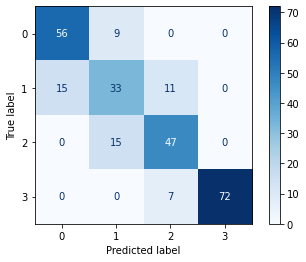

In [55]:
disp = plot_confusion_matrix(classifier, X_pred, Y_test.argmax(axis=1),
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues)
plt.show()

In [56]:
print(cnf_matrix.sum(axis=0))
print(np.diag(cnf_matrix) )
print(cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) )

[71 57 65 72]
[56 33 47 72]
[15 24 18  0]


In [57]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

In [58]:
# Print the precision and recall, among other metrics
print(classification_report(Test_Y_final, predicted_labels, digits=3))

              precision    recall  f1-score   support

           0      0.789     0.862     0.824        65
           1      0.579     0.559     0.569        59
           2      0.723     0.758     0.740        62
           3      1.000     0.911     0.954        79

    accuracy                          0.785       265
   macro avg      0.773     0.773     0.772       265
weighted avg      0.790     0.785     0.786       265

